# Group Project Report

## Introduction



The data set proposed describes the tennis players' statisitcs which were collected by Ultimate Tennis Statisitcs (https://www.ultimatetennisstatistics.com/). 

Tennis, a widely popular individual sport with a rich history dating back to the 19th century, engages millions of players globally. Its period of most rapid growth as both a participant and a spectator sport began in the late 1960s. Performance in this sport is assessed through global rankings, primarily administered by the Association of Tennis Professionals (ATP) for men and the Women's Tennis Association (WTA) for women. The impact of age on player rankings, known as the Relative Age Effect (RAE), has become a subject of extensive studies.

Studies such as "The relative age effect in top 100 elite female tennis players in 2007–2016" by Zháněl J, Válek T, Bozděch M, Agricola A (2022) revealed that over half of the top 100 players were born in the first half of the year. Another research piece, "Biological age vs. chronological age: the impact on the development of the young tennis athlete," emphasized that the relative age effect is one of many variables directly influencing a player's tennis level. Consequently, a player's age significantly affects performance and ranking.

Considering the direct correlation between age and a player's ranking, impacting health, strength, and mentality, we propose the following question: Can we predict a player's ranking based on their age?

To address this inquiry, we will analyze the "Player Stats for Top 500 Players" data set. This comprehensive data set encompasses various aspects of the top 500 tennis players globally, including names, ages, countries, and more. In this project, we aim to leverage the players' ages and their corresponding rankings in the data collection to predict the ranking of another player, given their age, as well as raising questions about the length of players' careers in the future and how age affects changes in rankings over time.

## Importing libraries

In [1]:
set.seed(2000)
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
install.packages("kknn")
library(kknn) 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

## Loading in and tidying data

**First, we will read our data directly from web with the exact link to source**

In [2]:
url <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
download.file("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS", destfile = "data/player_stats.csv")
player_stats <- read_csv(url)

head(player_stats) 

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,21 (29-05-1998),"Korea, Republic of",Right-handed,Wikipedia,236 (199),130 (10-04-2017),Duck Hee Lee,Two-handed,"$374,093",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,27 (21-10-1992),Australia,Right-handed,Wikipedia,183 (273),17 (11-01-2016),Bernard Tomic,Two-handed,"US$6,091,971",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,22 (11-02-1997),Poland,Right-handed,Wikipedia,31 (1398),31 (20-01-2020),Hubert Hurkacz,Two-handed,"$1,517,157",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


**Interpretation**Because regression model and functions only works with numerical values like integers or doubles, we would have to convert out age and current ranking data to fit those requirements.

We can see that for multiple columns, there are more than one variable in one cell. For example, player age and birthday, current rank and points. There are also missing values for several cells we are interested in. After careful inspection, we concluded that this dataset is from four years ago (Nadal is 37 this year, not 33). We see that John Millman's `age` is not available, since he is 34 years old this year, we can replace the `NA` in his age with his age four years ago, which is 30. There are also multiple `NA` in the `current_rank` column, so we can also fill those in using the website where the dataset was from to wrangle our data.

Because regression model and functions only works with numerical values like integers or doubles, we would also have to convert out age and current ranking data to fit those requirements.

In [3]:
player_stats_complete <- player_stats |>
    separate("Age", into = c("age", "birthday"), sep = "\\(")|>
    separate("Current Rank", into = c("current_rank", "points"), sep ="\\(") |>
    rename(name = Name)|>
    select(name, age, current_rank)|>
    mutate(current_rank = as.numeric(current_rank))|>
    arrange(current_rank)|>
    mutate(age = ifelse(is.na(age), 30, age))|>
    mutate(current_rank = ifelse(is.na(current_rank),
                             case_when(
                                 name == "Scott Griekspoor" ~ 472,
                                 name == "Brandon Holt" ~ 499,
                                 name == "Evan Song" ~ 314,
                                 name == "John Millman" ~ 48,
                                 name == "Sebastian Fanselow" ~ 494),
                             current_rank))|>
    arrange(current_rank)|>
    as_tibble() |>
    select(-name) |>
    mutate(age = as.numeric(age), current_rank = as.numeric(current_rank))
    
head(player_stats_complete)

age,current_rank
<dbl>,<dbl>
33,1
32,2
38,3
23,4
26,5
21,6


Table 1: 2019's top 500 tennis players age and ranking (complete with just the variables we need - age and current ranking).

**We can plot this to see what the relationship between player's age and current ranking looks like.**

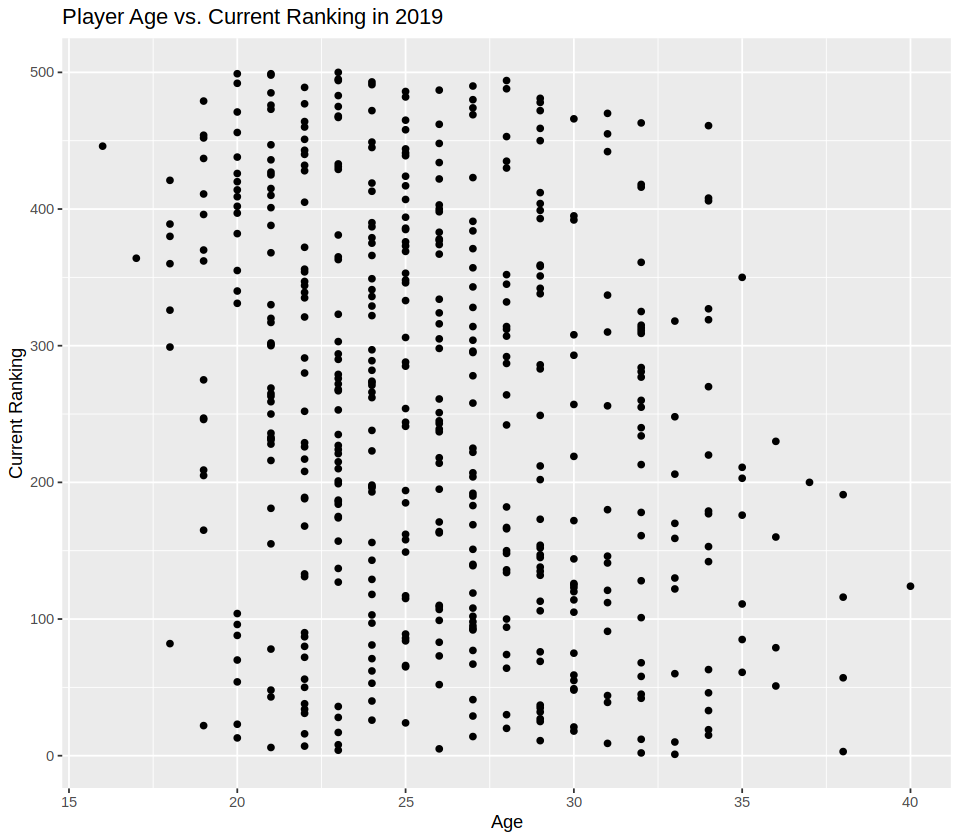

In [4]:
options(repr.plot.width = 8, repr.plot.height = 7)
player_stats_plot <- player_stats_complete |>
    ggplot(aes(x = age, y = current_rank))+
    geom_point()+
    labs(x = "Age", y = "Current Ranking")+
    ggtitle("Player Age vs. Current Ranking in 2019")

player_stats_plot

Figure 1: Relationship between player's age and 2019 ranking.

Based on this plot alone, it is difficult to determine whether the relationship between player's age and ranking is positive or negative. To get a better sense of what the relationship looks like, we can also look at the average ranking of each age in the top 500 players.

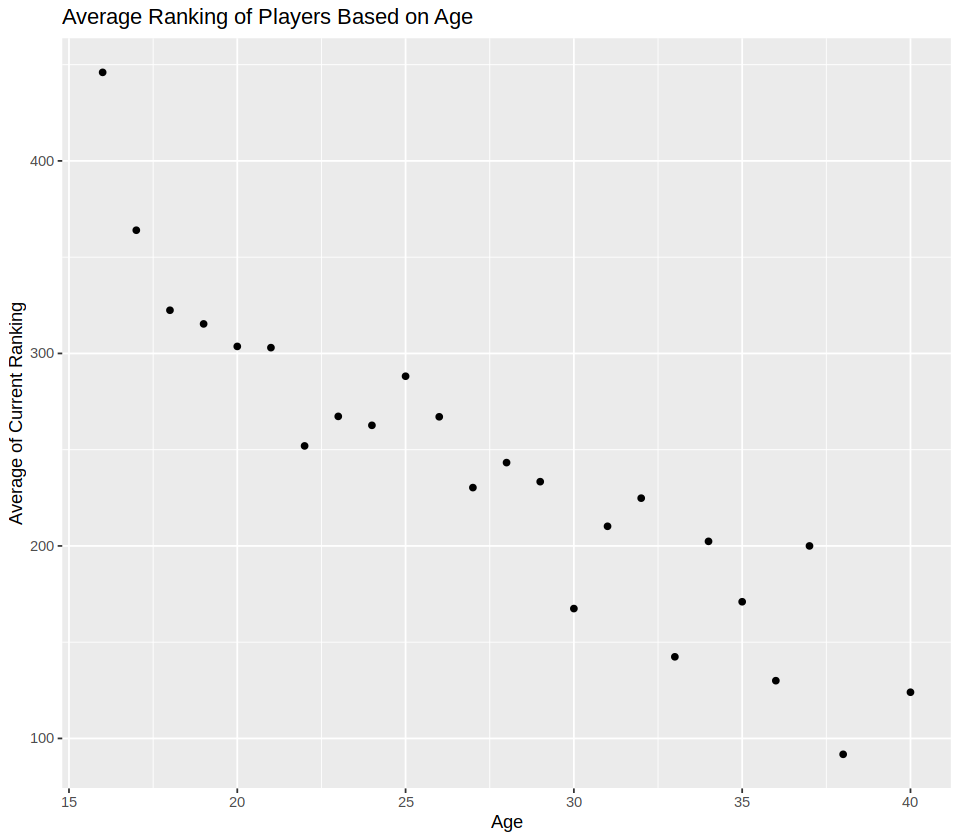

In [5]:
options(repr.plot.width = 8, repr.plot.height = 7)
avg_current_rank <- player_stats_complete|>
    group_by(age)|>
    summarize(current_rank = mean(current_rank))

avg_rank_plot <- avg_current_rank|>
    ggplot(aes(x = age, y = current_rank))+
    geom_point()+
    labs(x = "Age", y = "Average of Current Ranking")+
    ggtitle("Average Ranking of Players Based on Age")

avg_rank_plot

Figure 2: Relationship between player's age and average 2019 ranking.

With this plot, we know that we are expecting to see a negative relationship between player's age and their current ranking: as players get older, they will be higher up in the rankings. <br>
With a clean and complete data set, we can now split our data into training and testing sets. For our training set, we will be using 75% of our original 
`player_stats_complete` data.

## Splitting up the data 

In [6]:
set.seed(2000) 
player_stats_split <- initial_split(player_stats_complete, prop = 0.75, strata = current_rank)
player_stats_train <- training(player_stats_split)
player_stats_test <- testing(player_stats_split) 

## Creating prediction model

### Using K-nn regression

We'll use cross-validation on our training data to choose k. Using RMSPE, we can determine the k value that correspond to the most precise prediction model.

To do that, **we will fisrt create a model specification for k-nn regression and a recipe to preprocess our data with the response variable "current_rank".**

In [7]:
lm_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn")|>
    set_mode("regression")

ps_recipe <- recipe(current_rank ~ age , data = player_stats_train) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())


ps_recipe
lm_spec

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Scaling for all_predictors()
Centering for all_predictors()

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


<br>

**Interpretation**

Now, we will create cross validation with 5 folds using the vfold function and then adding it to the workflow to combine our model specification and recipe.


In [8]:
set.seed(2000) 
ps_vfold <- vfold_cv(player_stats_train, v = 5, strata = current_rank) 
ps_workflow <- workflow() |>
    add_recipe(ps_recipe) |>
    add_model(lm_spec) 

<br>Next, we will test the value of k from one to 81, increasing with intervals of 5 (1, 6, 11, 16, 21,...) to find the best k value using RMSPE from the workflow created. After that, we will collect the statistics from the model and put it in** `results` variable </br>

In [9]:
set.seed(2000) 
gridvals <- tibble(neighbors = seq(from = 1, to = 81, by = 5))
results <- ps_workflow |> 
    tune_grid(resamples = ps_vfold, grid = gridvals) |>
    collect_metrics() 
results 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,2.530005e+02,5,3.303718990,Preprocessor1_Model01
1,rsq,standard,1.319939e-02,5,0.008347766,Preprocessor1_Model01
6,rmse,standard,2.039230e+02,5,3.580217233,Preprocessor1_Model02
6,rsq,standard,8.304744e-03,5,0.003843302,Preprocessor1_Model02
11,rmse,standard,1.720728e+02,5,3.240002783,Preprocessor1_Model03
11,rsq,standard,1.866517e-02,5,0.009427297,Preprocessor1_Model03
16,rmse,standard,1.524864e+02,5,2.109767143,Preprocessor1_Model04
16,rsq,standard,3.398665e-02,5,0.015731477,Preprocessor1_Model04
21,rmse,standard,1.429728e+02,5,3.413939947,Preprocessor1_Model05


In [10]:
set.seed(2000) 
neighbors_min <- results |>
    filter(.metric == "rmse") |>
    slice_min(n = 1, order_by = mean) 
neighbors_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
66,rmse,standard,140.082,5,2.325989,Preprocessor1_Model14


<br>With the best k value of 66, we can create the best possible model specification and using that model to make predictions on the test data. Using the `metrics` function to compute a summary of the regressions quality</br>

In [11]:
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = pull(neighbors_min, neighbors)) |>
    set_engine("kknn") |>
    set_mode("regression") 

best_fit <- workflow() |> 
    add_recipe(ps_recipe) |> 
    add_model(best_spec) |> 
    fit(data = player_stats_train) 

quality_summary <- best_fit |>
           predict(player_stats_test) |>
           bind_cols(player_stats_test) |>
           metrics(truth = current_rank, estimate = .pred)
quality_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,138.05227807
rsq,standard,0.06642184
mae,standard,118.31593277


**Interpretation:**

RMSPE is measured in the units of the target/response variable so in this case, this model allows us to predict a tennis player's ranking based on their age up to $\pm 138$ ranks. This is not great but it's not terrible because a player's performance can rely on many things while we are just looking at the age factor. We can certainly estimate the range of rank which a player would fall in based on their age but the model can not reliably predict exactly what the ranking would be. The RMSPE value from the testing data is roughly the same as our validation RMSPE of our best model so we can say that we have similar performance on the test data when compared to the training data. 

Here's a graph to make it easier to visualize our model prediction

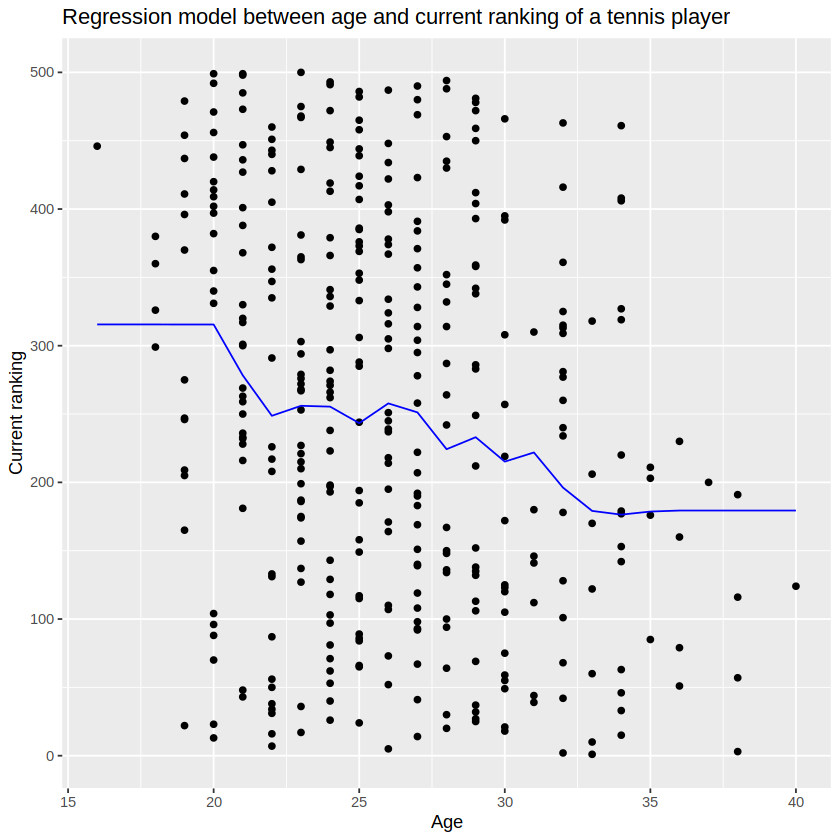

In [12]:
set.seed(2000)

options(repr.plot.width = 7, repr.plot.height = 7)

# your code here
tennis_pred <- best_fit |>
predict(player_stats_train) |>
bind_cols(player_stats_train)

tennis_plot <- player_stats_train |>
ggplot(aes(x = age, y = current_rank)) +
geom_point() + 
ggtitle("Regression model between age and current ranking of a tennis player") +
geom_line(data = tennis_pred, mapping = aes(x = age, y = .pred), color = "blue") +
xlab("Age") +
ylab("Current ranking")
tennis_plot

### Using linear regression

**An alternative solution is to use a linear regression model to predict the current ranking of a player, providing their age. We choose to do both method to compare and decide the superior model.**

In [13]:
lm_spec <- linear_reg() |>
    set_engine("lm")|>
    set_mode("regression")

ps_recipe <- recipe(current_rank ~ age, data = player_stats_train)

ps_fit <- workflow() |>
    add_recipe(ps_recipe) |>
    add_model(lm_spec) |>
    fit(data = player_stats_train)

ps_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          age  
    472.676       -8.511  


**Interpretation:**
<br>Aside from the intercept, all variables (`age`) have a negative relationship with the `current_rank`. We can interpret this as the player's age increase, the numerical value of their ranking decreases, meaning they will be higher up in the rankings. This is consistent with what we expected when we plotted the average ranking of players based on age.</br>


We can visualize the model predictions on the training data with a scatterplot.

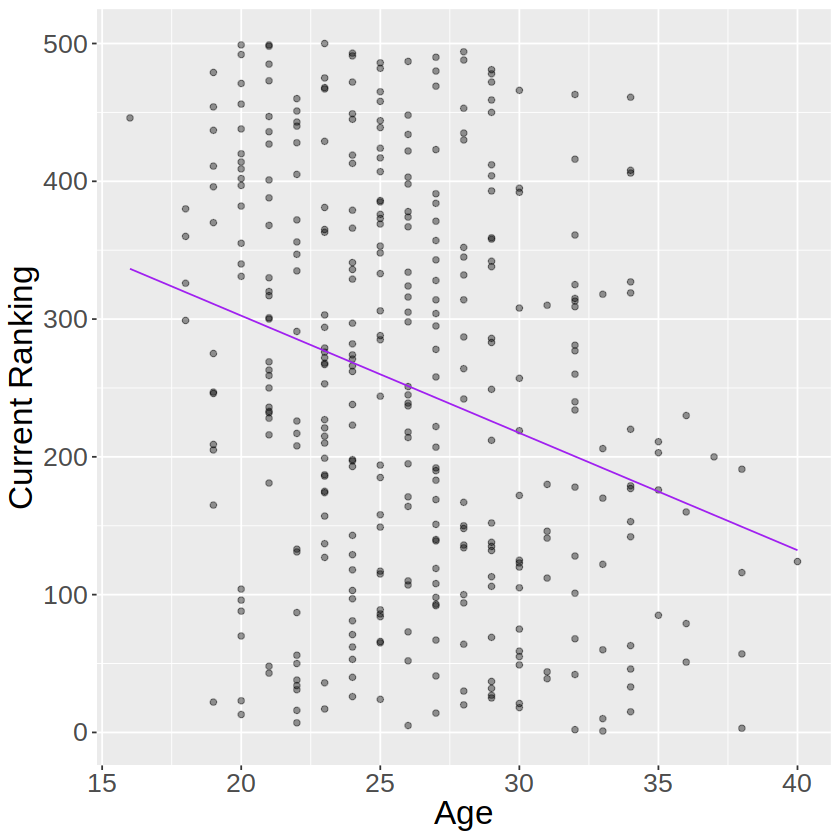

In [14]:
player_stats_preds <- ps_fit |>
  predict(player_stats_train) |>
  bind_cols(player_stats_train)

lm_predictions <- player_stats_preds |>
    ggplot(aes(x = age, y = current_rank)) +
    geom_point(alpha = 0.4) +
    geom_line(
        mapping = aes(x = age, y = .pred),
        color = "purple") +
    labs(x = "Age", y = "Current Ranking")+
    theme(text = element_text(size = 20))
lm_predictions

Figure 3: Model predictions as a straight line overlaid on the training data.

We can now calculate the *RMSE* as a single numeric value to assess goodness of fit on `ps_fit`.

In [15]:
lm_rmse <- best_fit |>
    predict(player_stats_train) |>
    bind_cols(player_stats_train) |>
    metrics(truth = current_rank, estimate = .pred) |>
    filter(.metric == "rmse") |>
    select(.estimate)|>
    as.numeric()
lm_rmse

[1] 139.5208

We can also evaluate how well our model is doing by calculating the *RMSPE* as a single numeric value using the test data.

In [16]:
lm_rmspe <- ps_fit|>
    predict(player_stats_test)|>
    bind_cols(player_stats_test)|>
    metrics(truth = current_rank, estimate = .pred)|>
    filter(.metric == "rmse")|>
    select(.estimate)|>
    as.numeric()
lm_rmspe

[1] 136.8792

Once again, we can visualize the model predictions with a scatterplot, this time on the testing data instead.

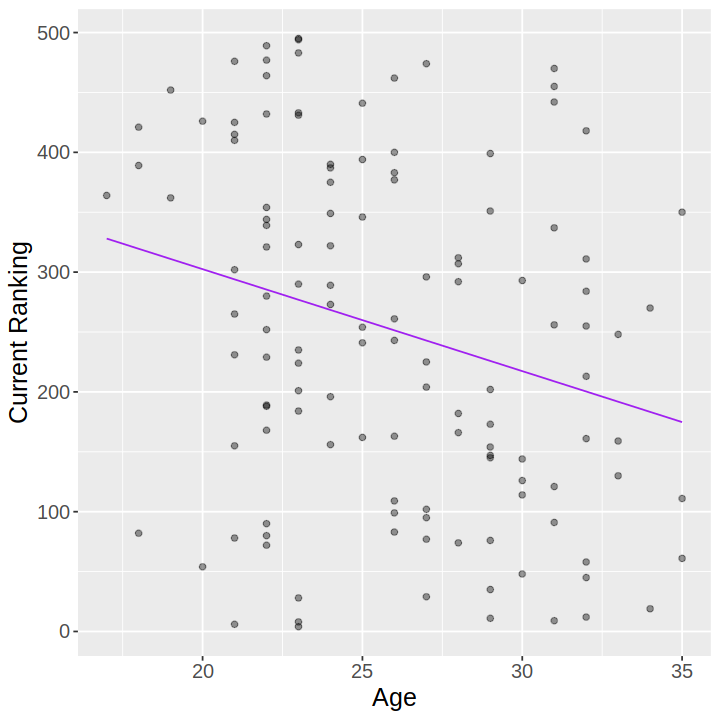

In [17]:
options(repr.plot.width = 6, repr.plot.height = 6) 
test_preds <- ps_fit |>
  predict(player_stats_test) |>
  bind_cols(player_stats_test)

lm_predictions_test <- test_preds |>
    ggplot(aes(x = age, y = current_rank)) +
    geom_point(alpha = 0.4) +
    geom_line(
        mapping = aes(x = age, y = .pred),
        color = "purple") +
    labs(x = "Age", y = "Current Ranking")+
    theme(text = element_text(size = 15))
lm_predictions_test

Figure 4: Model predictions as a straight line overlaid on the test data.

## Discussion

* Summarize what you found
    * Linear regression: 
        * based on equation: negative relationship
        * rmse = 139.520771868754
        * rmspe = 136.879232448018
    * K-nn regression: 
        * based on equation: negative relationship
        * rmse =  140.082
        * rmspe = 138.05227807
* Discuss whether this is what you expected to find?
    * expected negative relationship
    * lots of fluctuations in ranking (player experience, talent)
* discuss what impact could such findings have?
* discuss what future questions could this lead to?

The mean age of top 100 male tennis players increased significantly from 1984 to 2013 (24.6 ± 3.9 to 27.6 ± 3.2 yr; P < 0.01) and it was also observed in female tennis players from 1998 to 2013 (23.5 ± 3.5 to 24.8 ± 4.2 yr; P < 0.01) (Salazar, 2015). This literature answers the questions we have proposed, there is a negative relationship was discovered between the age of a player and their subsequent ranking in the top 500. In short, as a player gets older, they tend to rank higher, which was expected. This conclusion is more fully confirmed after analyzing data from 500 tennis players.

When comparing between 2 models - linear regression and k-nn regression, the results of RMSE and RMSPE were approximately the same to each other. We initially thought that because the relationship between the response variable and predictor is not linear, k-nn regression would yielded better results. However, this is false since there's a lot of fluctuations in the data when exploring the relationship between a player's age and their ranking. This explains why both models perform the same in predicting this relationship.

In terms of the RMSE and RMSPE, for the linear regression model, the calculated RMSE was 139.520771868754, and the calculated RMSPE was 136.879232448018; and for the k-nn regression model counterpart, the calculated RMSE was 140.082, and the calculated RMSPE was 138.05227807. Considering that a perfect RMSE and RMSPE would be zero, this is leaves something to be desired. However, there is a lot to be considered when assessing a player's ranking, such as current health, athletic ability or talent, experience levels, and a plethora of other factors. Based on the data on hand, the factors were limited to just age, meaning that our model could not account for these other fluctuations. 

While there was a correlation established between a player's age and the average ranking associated with that age, this does not mean that age is the cause of a player's better ranking. The only foreseeable impact this correlation could have would be the establishment of a "prime" age for tennis. In order too have a larger impact on the sport, the model would need to take most other measurable factors into account. The establishment of a "prime" age for tennis may make it so that in the future the range of player ages is smaller.

**References**

* At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
* Make sure to cite the source of your data as well.

Utimate Tennis Statistics. https://www.ultimatetennisstatistics.com/

Gallo-Salazar, Cesar & Salinero, Juan & Sanz, David & Areces, Francisco & Del Coso, Juan. (2015). Professional tennis is getting older: Age for the top 100 ranked tennis players. International Journal of Performance Analysis in Sport. 15. 873-883. 10.1080/24748668.2015.11868837. 

Zháněl, J., Válek, T., Bozděch, M., & Agricola, A. (2022). The relative age effect in top 100 elite female tennis players in 2007–2016. PLOS ONE, 17(11), e0276668. https://doi.org/10.1371/journal.pone.0276668

Brito, A. V. (2020). Biological age vs. chronological age: the impact on the development of the young tennis athlete. ITF Coaching & Sport Science Review, 28(80), 38–41. https://doi.org/10.52383/itfcoaching.v28i80.69